# 과거 주가 데이터로 미래 주가를 예측할 수 있을까? | 파이썬 패턴 검색기 구현

주가 예측은 오래 전부터 많은 사람들의 관심을 받아왔다. 주가의 오르내림은 정규분포에 매우 근사하기 때문에 예측이 불가능하다는 주장(패턴의 규칙이 없다는 뜻)도 있고 강화학습, 딥러닝이 단기간 예측을 가능하게 한다는 주장도 있다. 결국 어느 쪽이 맞을지는 모르겠지만 하락장에서도 AI 로보어드바이저가 돈을 벌었다는 기사들을 보면 숨은 보석같은 공식을 찾아내고 싶은 욕구가 생긴다.

AI까지 가지 않더라도 단타 세계에서는 이미 차트 매매법이라고 해서 과거 차트 패턴에 따라 앞으로의 주가를 예측할 수 있다는 전문가들이 많다. 그들의 유튜브 구독자 수만 봐도 얼마나 많은 사람들이 단타와 차트매매기술에 관심이 많은지 알 수 있다. 이들 세계에서는 그들만 아는 비밀의 법칙과 매매 기술들이 존재하겠지만 널리 알려진 것들도 많다. 이번에는 아쉬운대로 알려진 것들 중 **현재 차트와 유사한 차트를 찾아서 매매에 활용하는 패턴 검색**을 파이썬으로 구현해보려고 한다. 

**패턴 검색**을 하는 이유를 1차원 적으로 생각하면 유사한 차트에서 다음 날짜에 주가가 올랐다면 매수하고, 내렸다면 매도하기 위해서다. 물론 이에 따른 손익은 전적으로 본인의 책임이다.


```
목차
___
Step 1. 라이브러리 호출 및 코스피 지수 추출
Step 2. 기준 구간 지정 및 시각화
Step 3. 패턴 검색기 구현
Step 4. 검색 구간 이후의 추세 확인
```

## 1. 라이브러리 호출 및 코스피 지수 추출

주가 데이터를 가져오기 위해 FinanceDataReader라는 파이썬 오픈소스를 사용하고 matplotlib을 통해 주가 차트를 시각화할 것이다. 따라서 해당 라이브러리를 import해준다.

또한 패턴 검색을 구현하기 위해 과거 데이터와 현재 데이터를 서로 '코사인 유사도'로 비교할텐데 이를 위해 scipy 패키지의 cosine함수를 사용하겠다.

In [1]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

import yfinance as yf
from scipy.spatial.distance import cosine

In [2]:
# 코스피 지수 추출
kospi = yf.Ticker('^KS11').history(start='2010-01-01', end='2022-06-15')
kospi

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,1681.709961,1696.140015,1681.709961,1696.140015,296500,0,0
2010-01-05,1701.619995,1702.390015,1686.449951,1690.619995,408900,0,0
2010-01-06,1697.880005,1706.890015,1696.099976,1705.319946,426000,0,0
2010-01-07,1702.920044,1707.900024,1683.449951,1683.449951,462400,0,0
2010-01-08,1694.060059,1695.260010,1668.839966,1695.260010,380000,0,0
...,...,...,...,...,...,...,...
2022-06-08,2633.530029,2639.520020,2621.959961,2626.149902,576000,0,0
2022-06-09,2618.919922,2627.879883,2606.610107,2625.439941,814500,0,0
2022-06-10,2596.370117,2602.800049,2583.739990,2595.870117,723800,0,0


## 2. 기준 구간 지정 및 시각화

패턴 검색을 위해서는 종가만 있으면 된다. 더 복잡한 `무언가`를 구현하고자 한다면 나머지 칼럼도 활용해보길 바란다.

종가 데이터는 'Close' 칼럼에 있다. 이와 함께 현재 어느 시점의 차트를 기준으로 검색할 것인지 날짜 구간을 변수에 저장해준다.

In [3]:
# 종가만 추출
kospi_close = kospi['Close']

# 비교 기준 구간
d_start = '2022-01-01'
d_end = '2022-06-02'

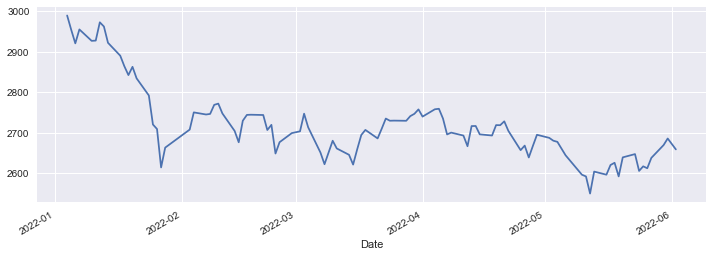

In [11]:
# 기준 구간 시계열 차트
plt.figure(figsize=(12,4))
plt.style.use('seaborn')
kospi_close[d_start:d_end].plot();

위 차트와 유사한 과거의 차트를 찾아내는 것이 이번 분석의 목적이다.

## 3. 패턴 검색기 구현

패턴 검색의 원리는 이렇다. 먼저 앞에서 지정한 기준 구간의 데이터가 있을 것이다. 해당 데이터 길이만큼 최초 상장일부터 하루씩 비교하면서 코사인 유사도를 계산한다. 단, 과거의 주가와 현재 주가의 액수 차이가 크기 때문에 `패턴`만 추출하기 위해서 표준화를 먼저 수행한 다음 데이터를 비교해야 한다. 

이렇게 모든 데이터를 비교해서 코사인 유사도가 가장 작은 값 즉, 현재 주가 패턴과 가장 유사한 과거 시점의 주가를 찾는 방식이다. 코드로 구현해보자.

In [5]:
count = 0
compare_base_r = kospi_close[d_start:d_end]
# series에서 값만 추출
compare_base = compare_base_r.values
# 표준화
compare_base_norm = (compare_base - compare_base.mean()) / compare_base.std()
# array -> 1차원 리스트로 변환
compare_base_norm = list(compare_base_norm)

# 검색 기간
window_size = len(compare_base_norm)
# 검색 기간에 더해서 추가로 보여줄 기간
next_date = 7
# 검색 횟수
moving_cnt = len(kospi_close) - 2*(window_size-1) - next_date

# 유사도 저장 딕셔너리
sim_dict = {}

for i in range(moving_cnt):
    compare_target_r = kospi_close[i:i+window_size]
    # series에서 값만 추출
    compare_target = compare_target_r.values
    # 표준화
    compare_target_norm = (compare_target - compare_target.mean()) / compare_target.std() 
    # array -> 1차원 리스트로 변환
    compare_target_norm = list(compare_target_norm)

    # 코사인 유사도 저장
    sim = cosine(compare_base_norm, compare_target_norm)
    # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
    sim_dict[sim] = [i,compare_target_r]

이렇게 반복문을 통해 모든 코사인 유사도를 단일 리스트에 저장했다면, 이 값이 가장 작았던 구간을 추출해야 한다. 다행히 우리는 반복문에서 인덱스를 함께 저장했기 때문에 간단하게 불러낼 수 있다.

In [6]:
# 최소 코사인 유사도
min_sim = min(list(sim_dict.keys()))
# 최소 코사인 유사도가 나온 인덱스, 기간 추출
sim_dict[min_sim]

[1154,
 Date
 2014-08-27    2074.929932
 2014-08-28    2075.760010
 2014-08-29    2068.540039
 2014-09-01    2067.860107
 2014-09-02    2051.580078
                  ...     
 2015-01-19    1902.619995
 2015-01-20    1918.310059
 2015-01-21    1921.229980
 2015-01-22    1920.819946
 2015-01-23    1936.089966
 Name: Close, Length: 100, dtype: float64]

그래서 이때의 주가 패턴이 얼마나 현재 패턴과 유사한지 궁금할 것이다. 두 그래프를 동시에 그려보자. 단, 주 시점의 주가 차이를 상쇄하기 위해 앞에서 유사도를 계산할 때 표준화를 했던 것처럼 이번에도 역시 표준화를 진행하고 그래프를 그릴 것이다.

In [7]:
# 표준화된 기준 구간 데이터 
compare_base_norm

[2.8741732345009217,
 2.4971152595282913,
 2.139621933541546,
 2.506949784258656,
 2.205796174521818,
 2.2128510366094445,
 2.694998529560686,
 2.583924254361606,
 2.1544807311238086,
 1.8143074439137883,
 1.5378471564895781,
 1.3030818087064449,
 1.5211691806331475,
 1.2176639502004345,
 0.7655576938857375,
 2.0619093758480324e-06,
 -0.11919718024448753,
 -1.1321323473770857,
 -0.6098950720855043,
 -0.13437700928689764,
 0.3193317943166646,
 0.2637411514737669,
 0.2788139700294613,
 0.5180711482427852,
 0.5509964479969123,
 0.29207022032285895,
 -0.17008458169563434,
 -0.4687795602498807,
 0.09931823362907827,
 0.25337157430982343,
 0.25796780521485857,
 0.2502708802069377,
 -0.14538864937113563,
 -0.00919039990069437,
 -0.7653369390816832,
 -0.4664279395540053,
 -0.2267453294056895,
 -0.18034714837286206,
 0.28533638969537994,
 -0.07440415651239637,
 -0.7385034070347406,
 -1.0475705727648015,
 -0.42836874644939316,
 -0.6319183522539804,
 -0.7990139222546917,
 -1.0568700450615875,
 -0

In [8]:
# 검색 구간 데이터 -> 값만 추출
compare_target = compare_target_r.values
# 검색 구간 데이터 표준화
compare_target_norm = (compare_target - compare_target.mean())/compare_target.std()
compare_target_norm = list(compare_target_norm)

# 표준화된 검색 구간 데이터
compare_target_norm

[2.4477763309457883,
 2.340917173477358,
 2.155691134445625,
 1.913060613229205,
 1.7814754304013225,
 1.3827515398793042,
 1.0795959288832093,
 1.2498776957148874,
 0.593040975984155,
 0.19184212081783542,
 0.511123058192072,
 1.028101966718636,
 1.1195864233532198,
 0.9230721309438193,
 0.9807994346038496,
 1.0914195934882758,
 1.683542417954386,
 1.7668566042414513,
 1.4317731619644165,
 1.702785727362676,
 1.7271889312467843,
 1.556151289741131,
 1.2935242090072858,
 0.7743957818766045,
 0.8932938182669973,
 0.9158703250223316,
 1.141302072840971,
 1.190428677519691,
 0.9398431002726483,
 1.0518595276520568,
 0.9128599491506311,
 0.8877034951573876,
 0.9780042730490447,
 0.5940068158453458,
 0.18926217357992636,
 0.2811770588483018,
 -0.25246521184864307,
 -0.8653352213764737,
 -1.4443404707713028,
 -0.8944678911026085,
 -0.9284376338292177,
 -1.3575881045435856,
 -1.0562591906762644,
 -0.5807772768379815,
 -0.2967547435268886,
 -0.38684293166649014,
 -0.14646691164779557,
 -0.3175

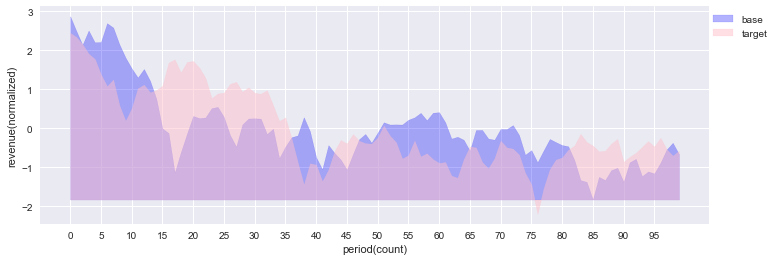

In [9]:
import numpy as np

xrange = np.arange(0, len(compare_base_norm),1)
plt.figure(figsize=(12,4))
plt.fill_between(x=xrange,
                 y1=np.min(compare_base_norm), y2=compare_base_norm, 
                 label='base', alpha=0.3, color='blue')
plt.fill_between(x=xrange,
                 y1=np.min(compare_base_norm), y2=compare_target_norm, 
                 label='target', alpha=0.5, color='pink')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xticks(xrange[::5])
plt.xlabel('period(count)')
plt.ylabel('revenue(normalized)')
plt.show()

두 그래프의 추세가 매우 유사하다. 복잡한 코드 없이 몇 줄 안되는 간단한 코드로 구현한 패턴 검색기임에도 나름대로 제 역할을 잘 하는 것 같다.

## 4. 검색 구간 이후의 추세 확인

이번에는 해당 구간 이후 주가가 어떻게 움직였는지 볼 것이다. 우리가 궁금한 것은 '앞으로의 주가가 어떻게 될 것인가?'이기 때문이다.

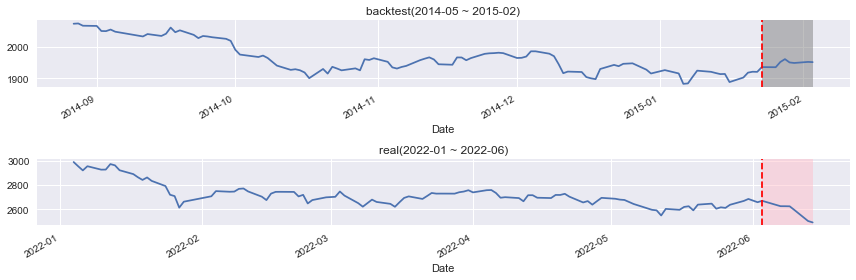

In [10]:
# 반복문 인덱스 복원
idx = sim_dict[min_sim][0]
# 반복문 타겟 구간 시계열 데이터 복원
compare_target_r = sim_dict[min_sim][1]

plt.figure(figsize=(12,4))
expanded_target_r = kospi_close[idx:idx+window_size+next_date]
plt.subplot(211)
expanded_target_r.plot()
plt.axvspan(compare_target_r.index[-1], expanded_target_r.index[-1], facecolor='gray', alpha=0.5)
plt.axvline(x=compare_target_r.index[-1], c='r', linestyle='--')
plt.title('backtest(2014-05 ~ 2015-02)')

plt.subplot(212)
loc = kospi_close.index.get_loc(kospi_close.loc[d_start:].index[0])
expanded_real_r = kospi_close[loc:loc+window_size+next_date]
expanded_real_r.plot()
plt.axvspan(expanded_real_r.index[-next_date], expanded_real_r.index[-1], facecolor='pink', alpha=0.5)
plt.axvline(x=expanded_real_r.index[-next_date], c='r', linestyle='--')
plt.title('real(2022-01 ~ 2022-06)')

plt.tight_layout()
plt.show()